In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import csv
import seaborn as sns

COLUMNS = ['AMB', 'CH4', 'CO', 'NMHC', 'NO', 'NO2',
        'NOx', 'O3', 'PM10', 'PM2.5', 'RAINFALL', 'RH',
        'SO2', 'THC', 'WD_HR', 'WIND_DIR', 'WIND_SPEED', 'WS_HR']

# Read in training set

In [4]:
def read_trainData(filename):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[1:row, 3:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)

    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    month_to_data = {}  ## Dictionary (key:month , value:data)                                  

    # generate month_to_data(20 days data)
    for month in range(12):
        sample = np.empty(shape = (18 , 480))
        for day in range(20):
            for hour in range(24): 
                sample[:,day * 24 + hour] = data[18 * (month * 20 + day): 18 * (month * 20 + day + 1),hour]
        month_to_data[month] = sample  

    return month_to_data

# 分析圖

================= Feature Selection - top_n =================
與 PM2.5 排名最的前 17 個特徵：
PM10          0.816310
CO            0.600925
NMHC          0.511133
NO2           0.499470
NOx           0.463238
THC           0.303378
SO2           0.297900
NO            0.233854
CH4           0.218112
O3            0.101997
RH            0.084675
WIND_DIR     -0.011948
WD_HR        -0.017137
RAINFALL     -0.077858
WIND_SPEED   -0.146933
WS_HR        -0.162156
AMB          -0.291249
Name: PM2.5, dtype: float64
================= analysis graph =================


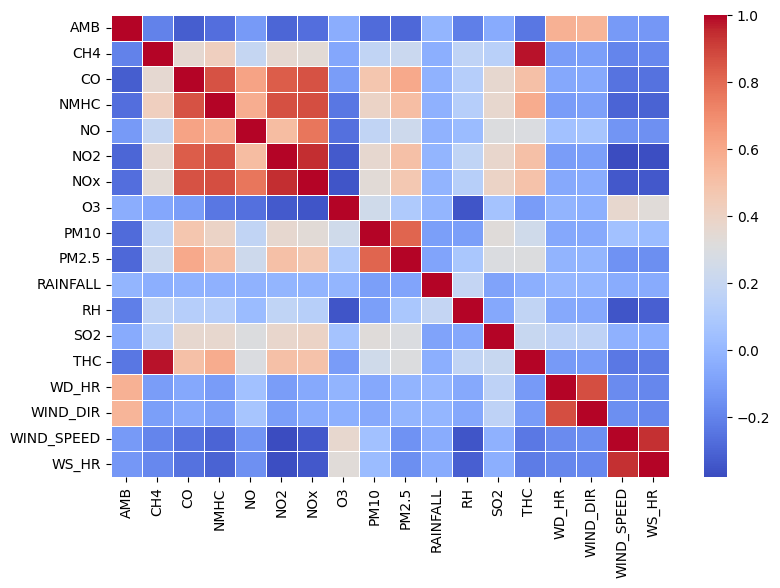

In [5]:

def analysis_graph(month_to_data, top_n, threshold, method='top_n'):
    data_features = np.vstack([value.T for value in month_to_data.values()])

    df_data_features = pd.DataFrame(data_features, columns=COLUMNS)
    label = np.array(df_data_features['PM2.5'][9:])
    corr_matrix = df_data_features.corr()


    print(f"================= Feature Selection - {method} =================")
 
    # 获取与 'PM2.5' 的相关性
    pm25_corr = corr_matrix['PM2.5']   
    if method == 'top_n':
        # 排序并找出与 PM2.5 最相关的前 N 个特征
        top_n =  top_n # 设置要找出的前 N 个相关特征
        top_pm25 = pm25_corr.drop('PM2.5').sort_values(ascending=False).head(top_n)
        need_features = top_pm25 
        print(f"與 PM2.5 排名最的前 {top_n} 個特徵：")
        print(top_pm25)

    elif method == 'threshold':
        # 设置一个阈值筛选出高于该值的相关性特征
        threshold = threshold  # 设定阈值 0.3
        high_corr_features = pm25_corr[pm25_corr > threshold].drop('PM2.5').sort_values(ascending=False)
        need_features = high_corr_features 
        print(f"與 PM2.5 相關性大於 {threshold} 的特徵：")
        print(high_corr_features)

    print("================= analysis graph =================")
    f,ax = plt.subplots(figsize=(9,6))
    sns.heatmap(corr_matrix, fmt='.3f', linewidths=0.5, ax=ax, cmap='coolwarm')
    plt.show()
    
    need_features = need_features.index.tolist() 
    return need_features

input_train_path = '../input_data/train.csv'
month_to_data = read_trainData(input_train_path)
need_features = analysis_graph(month_to_data, top_n=17, threshold=0.2, method='top_n')

# Preprocess

In [6]:

def select_features(month_to_data, need_feature_index):
    # 遍历字典并保留每个数组中的指定行
    for key, value in month_to_data.items():
        # 保留指定的行索引
        month_to_data[key] = value[need_feature_index, :]
        
    return month_to_data

need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
month_to_data = select_features(month_to_data, need_feature_index)

print(need_features)
print(need_feature_index)

['PM10', 'CO', 'NMHC', 'NO2', 'NOx', 'THC', 'SO2', 'NO', 'CH4', 'O3', 'RH', 'WIND_DIR', 'WD_HR', 'RAINFALL', 'WIND_SPEED', 'WS_HR', 'AMB']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 9]


In [7]:
def SetDataSets(month_to_data, feature_num, PM25_index):
    x = np.empty(shape = (12 * 471 , feature_num * 9),dtype = float)
    y = np.empty(shape = (12 * 471 , 1),dtype = float)

    for month in range(12): 
        for day in range(20): 
            for hour in range(24):   
                if day == 19 and hour > 14:
                    continue  
                x[month * 471 + day * 24 + hour,:] = month_to_data[month][:,day * 24 + hour : day * 24 + hour + 9].reshape(1,-1) 
                y[month * 471 + day * 24 + hour,0] = month_to_data[month][PM25_index ,day * 24 + hour + 9]
    return x, y

FEATURE_NUM = len(need_feature_index)
PM25_INDEX = FEATURE_NUM - 1
x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)
print(x.shape)
print(y.shape)
print(x[0])
print(y)

(5652, 162)
(5652, 1)
[11.1  11.2  11.4  11.5  11.6  11.7  11.9  12.1  12.7   2.01  1.99  2.
  2.02  2.03  2.02  2.02  2.01  2.03  0.31  0.28  0.28  0.33  0.32  0.26
  0.25  0.27  0.32  0.1   0.1   0.08  0.09  0.1   0.07  0.07  0.08  0.1
  1.5   1.4   1.4   1.5   1.4   1.3   1.4   1.9   3.2  11.9  10.4   9.8
 12.1  12.4   9.2   8.5   9.3  12.4  13.5  11.9  11.2  13.7  13.9  10.6
 10.   11.2  15.6  21.6  25.1  25.6  22.4  21.1  26.5  25.4  25.3  22.9
 38.   29.   27.   24.   29.   22.   26.   26.   31.    0.    0.    0.
  0.    0.    0.    0.    0.    0.   64.   65.   63.   63.   63.   63.
 63.   63.   62.    0.    2.1   2.1   1.8   1.1   0.7   0.8   0.8   0.
  2.11  2.09  2.08  2.11  2.13  2.09  2.09  2.09  2.13 38.   41.   49.
 54.   50.   44.   38.   37.   38.   53.   46.   43.   54.   50.   40.
 36.   37.   42.    3.    3.4   2.7   3.    2.6   2.7   2.4   3.1   3.3
  2.6   2.4   2.5   2.5   2.1   2.1   2.1   2.6   2.6  25.   24.   13.
 14.   15.   12.   10.   10.   11.  ]
[[11.]
 [1

In [8]:
MEAN = np.mean(x, axis = 0) 
STD = np.std(x, axis = 0)
def Normalization(x, mean, std):
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if not std[j] == 0 :
                x[i][j] = (x[i][j]- mean[j]) / std[j]
    return x    

x = Normalization(x, MEAN, STD)
print(x.shape)
print(y.shape)     
print(x)

(5652, 162)
(5652, 1)
[[-2.18550545 -2.17071969 -2.13963828 ... -0.38923435 -0.38911837
  -0.28608619]
 [-2.16914492 -2.13800313 -2.12328024 ... -0.38923435 -0.28635229
  -0.28608619]
 [-2.13642386 -2.12164485 -2.1069222  ... -0.28642803 -0.28635229
  -0.38890695]
 ...
 [-0.84394215 -0.86205714 -0.79827919 ... -0.08081538  0.6385425
   0.12519682]
 [-0.86030268 -0.79662402 -0.73284703 ...  0.6388289   0.12471207
   0.84494209]
 [-0.79486057 -0.73119089 -0.79827919 ...  0.12479728  0.84407468
   0.53647983]]


# Linear Regression Agrad

In [9]:
def RMSE(predict_Y, real_Y):
    N = len(predict_Y)  # 樣本數量
    loss = np.sqrt(np.sum((predict_Y - real_Y)**2) / N)
    return loss


In [10]:
# RMSE
def traininig(train_X, train_Y):
    dim = train_X.shape[1]
    w = np.zeros(shape = (dim, 1))
    learning_rate = np.array([[0.1]] * dim)
    adagrad_sum = np.zeros(shape = (dim, 1))  
    epoch = 20000
    print("================= traininig =================")
    for T in range(epoch):
        predict_Y = train_X.dot(w)   
        rmse_loss = RMSE(predict_Y, train_Y)
        gradient = np.transpose(train_X).dot(2 * (predict_Y-train_Y) / len(train_Y))
        
        adagrad_sum += gradient ** 2
        Sigma = np.sqrt(adagrad_sum)
        
        w = w - learning_rate * gradient / (Sigma + 0.0005)


        # if(T % 500 == 0 ):
        #     print("T=",T)
        #     print("Loss:",rmse_loss)
    
    print("T=",epoch)
    print("Loss:",rmse_loss)
    np.save('weight.npy',w)     ## save weight

In [11]:
dim = x.shape[1] + 1
x = np.concatenate((np.ones((x.shape[0], 1 )), x) , axis = 1).astype(float)
train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=0.2, random_state=42)

print(train_X.shape)
print(train_Y.shape)
 
traininig(train_X, train_Y)


(4521, 163)
(4521, 1)
================= traininig =================
T= 20000
Loss: 4.003879690329626


# predict valid

In [12]:
def validation(valid_X, valid_Y):
    
    w = np.load('weight.npy')   
    valid_predict_Y = valid_X.dot(w)

    predict_rmse = RMSE(valid_predict_Y, valid_Y)
    print("================= validation =================")
    for i in range(len(valid_Y)):
        print(f"predict_Y[i], Y[i]: {valid_predict_Y[i]}, {valid_Y[i]}")
        
    print(f"predict_rmse: {predict_rmse}")
    return predict_rmse
    
predict_rmse = validation(valid_X, valid_Y)
# 4.6049422315917035 0.3 20000
# 4.6034760721810075 0.2 20000
# 4.6144920448640200 0.1 20000

# 4.6034295855435925 0.2 30000

================= validation =================
predict_Y[i], Y[i]: [9.56010204], [8.]
predict_Y[i], Y[i]: [20.55869586], [21.]
predict_Y[i], Y[i]: [5.82511686], [4.]
predict_Y[i], Y[i]: [9.06864391], [9.]
predict_Y[i], Y[i]: [10.94406398], [10.]
predict_Y[i], Y[i]: [27.08712693], [21.]
predict_Y[i], Y[i]: [5.8831979], [10.]
predict_Y[i], Y[i]: [7.65700949], [12.]
predict_Y[i], Y[i]: [5.48052618], [6.]
predict_Y[i], Y[i]: [23.37509244], [23.]
predict_Y[i], Y[i]: [23.61036042], [28.]
predict_Y[i], Y[i]: [4.42551124], [4.]
predict_Y[i], Y[i]: [21.51428455], [23.]
predict_Y[i], Y[i]: [12.02072692], [11.]
predict_Y[i], Y[i]: [19.83686011], [15.]
predict_Y[i], Y[i]: [16.4687148], [22.]
predict_Y[i], Y[i]: [8.76290291], [7.]
predict_Y[i], Y[i]: [21.32964429], [22.]
predict_Y[i], Y[i]: [10.58226818], [8.]
predict_Y[i], Y[i]: [22.0422461], [22.]
predict_Y[i], Y[i]: [6.63253828], [5.]
predict_Y[i], Y[i]: [10.09115234], [11.]
predict_Y[i], Y[i]: [7.28613782], [7.]
predict_Y[i], Y[i]: [5.85424586]

# Read in Testing set

In [13]:
def read_testData(filename, feautre_num):
    # 讀入檔案
    raw_data = pd.read_csv(filename, header=None, encoding='utf8')

    # 去除標頭和多餘直行
    row, col = raw_data.shape
    raw_data  = raw_data.iloc[:, 2:col]              

    # 去除多餘空格
    raw_data = raw_data.replace(r'\s+', '', regex=True)  

    # 將特殊符號替換為 0
    special_chars = ['#', '*', 'x', 'A','WIND_DIR+D2070EC']  # 定義需要替換的特殊符號
    raw_data.replace(special_chars, 0.0, inplace=True)
    
    # 轉換成numpy & 浮點數型別
    data = raw_data.values 
    data = data.astype('float')

    test_row = 244
    test_x = np.empty(shape = (test_row, feautre_num * 9),dtype = float)

    for i in range(test_row):
        features_arr = data[18 * i : 18 * (i+1),:]
        clean_features = features_arr[need_feature_index, :]
        test_x[i, :] = clean_features.reshape(1, -1)


    return test_x


# predict test

In [14]:
def write_result(predict_Y):
    with open('../output/result.csv', "w", newline='') as f:
        w = csv.writer(f)
        title = ['index','answer']
        w.writerow(title) 
        for i in range(244):
            content = ['index_'+str(i),predict_Y[i][0]]
            w.writerow(content) 
    
    print("write complete!")

In [15]:
def testing(input_test_path, feautre_num, mean, std):
    test_X = read_testData(input_test_path, feautre_num) 
    test_X = Normalization(test_X, mean, std)
    test_X = np.concatenate((np.ones(shape = (test_X.shape[0],1)),test_X),axis = 1).astype(float)

    # print(test_X.shape)
    # print(test_X)
    print("================= testing =================")
    w = np.load('weight.npy') 
    predict_Y = test_X.dot(w)
    write_result(predict_Y)
 

input_test_path = '../input_data/test.csv'    
testing(input_test_path, FEATURE_NUM, MEAN, STD)

================= testing =================
write complete!


In [16]:
def save_diff_top_n_graph(valid_predict):
    x = np.arange(1,18)
    y = valid_predict
    plt.plot(x, y, 'ro--', linewidth=2, markersize=6)
    plt.savefig('../output/diff_top_n.png')
    plt.show()

def save_diff_test_size_graph(valid_predict):
    x = np.arange(0.5, 1, 0.1)
    y = valid_predict
    plt.plot(x, y, 'r*--', linewidth=1, markersize=4)
    plt.savefig('../output/diff_training_DataSets.png')
    plt.show()
    
    for i in range(len(x)):
        print(f"DataSets: {round(x[i], 1)}, valid_predict: {valid_predict[i]}")


# main

================= Feature Selection - top_n =================
與 PM2.5 排名最的前 6 個特徵：
PM10    0.816310
CO      0.600925
NMHC    0.511133
NO2     0.499470
NOx     0.463238
THC     0.303378
Name: PM2.5, dtype: float64
================= analysis graph =================


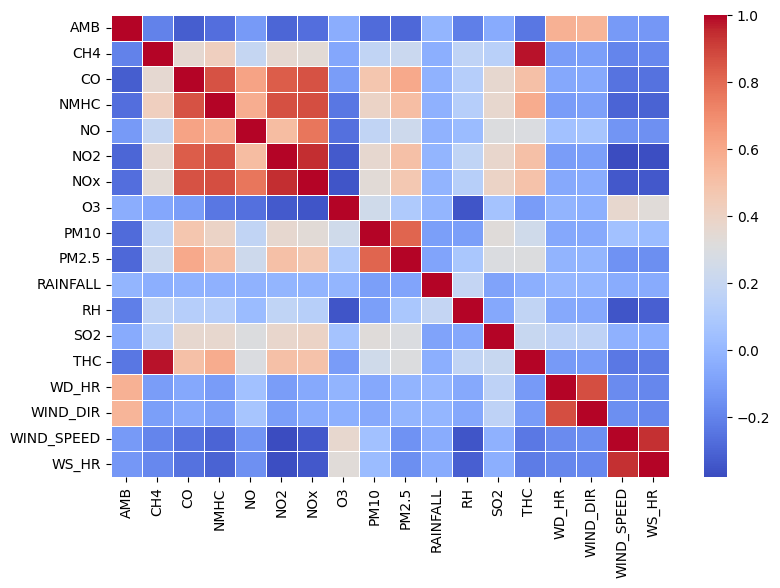

================= traininig =================
T= 20000
Loss: 4.171962710038267
================= validation =================
predict_Y[i], Y[i]: [9.64162594], [8.]
predict_rmse: 1.6416259355376397
================= testing =================
write complete!


In [17]:
if __name__=='__main__':
    input_train_path = '../input_data/train.csv'
    input_test_path = '../input_data/test.csv'    
    valid_predict = []
    
    #  difference feature 
    # for top_n in range(1,18):
    #     month_to_data = read_trainData(input_train_path)
    #     need_features = analysis_graph(month_to_data, top_n=top_n, threshold=0.2, method='top_n')
        
    #     need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    #     month_to_data = select_features(month_to_data, need_feature_index)
        
    #     FEATURE_NUM = len(need_feature_index)
    #     PM25_INDEX = FEATURE_NUM - 1

    #     x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
        
    #     MEAN = np.mean(x, axis = 0) 
    #     STD = np.std(x, axis = 0)   
    #     x = Normalization(x, MEAN, STD)    

    #     dim = x.shape[1] + 1
    #     x = np.concatenate((np.ones((x.shape[0], 1 )), x) , axis = 1).astype(float)
    #     train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=0.2, random_state=42)
    
    #     traininig(train_X, train_Y)

    #     predict_rmse = validation(valid_X, valid_Y)
    #     valid_predict.append(predict_rmse)
    
    # save_diff_top_n_graph(valid_predict)


    # # different train_dataSet
    # for test_size in range(1, 6, 1):
    #     month_to_data = read_trainData(input_train_path)
    #     need_features = analysis_graph(month_to_data, top_n=6, threshold=0.2, method='top_n')
        
    #     need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    #     month_to_data = select_features(month_to_data, need_feature_index)
        
    #     FEATURE_NUM = len(need_feature_index)
    #     PM25_INDEX = FEATURE_NUM - 1

    #     x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
        
    #     MEAN = np.mean(x, axis = 0) 
    #     STD = np.std(x, axis = 0)   
    #     x = Normalization(x, MEAN, STD)    

    #     dim = x.shape[1] + 1
    #     x = np.concatenate((np.ones((x.shape[0], 1 )), x) , axis = 1).astype(float)
    #     train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=round(test_size*0.1, 1), random_state=42)
    
    #     traininig(train_X, train_Y)

    #     predict_rmse = validation(valid_X, valid_Y)
    #     valid_predict.append(predict_rmse)
    
    # save_diff_test_size_graph(valid_predict)


    month_to_data = read_trainData(input_train_path)
    need_features = analysis_graph(month_to_data, top_n=6, threshold=0.2, method='top_n')
    
    need_feature_index = sorted([COLUMNS.index(feature) for feature in need_features]) + [9] # add PM2.5
    month_to_data = select_features(month_to_data, need_feature_index)
    
    FEATURE_NUM = len(need_feature_index)
    PM25_INDEX = FEATURE_NUM - 1

    x, y = SetDataSets(month_to_data, FEATURE_NUM, PM25_INDEX)    
    
    MEAN = np.mean(x, axis = 0) 
    STD = np.std(x, axis = 0)   
    x = Normalization(x, MEAN, STD)    

    dim = x.shape[1] + 1
    x = np.concatenate((np.ones((x.shape[0], 1 )), x) , axis = 1).astype(float)
    train_X, valid_X, train_Y, valid_Y = train_test_split(x, y, test_size=round(0.9), random_state=42)

    traininig(train_X, train_Y)

    predict_rmse = validation(valid_X, valid_Y)
    valid_predict.append(predict_rmse)
    
    testing(input_test_path, FEATURE_NUM, MEAN, STD)